In [1]:
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
from tinydb import TinyDB  

In [2]:
plt.rcParams.update({'font.size': 15})

In [3]:
save_1st_time = False

## Parameters

In [4]:
eps_I_list = [0.1,0.25,0.4]
eps_T_list = [0,0.01,0.1,0.4]

In [5]:
K = 10
nb_ideas = 20
k_threshold = np.full(nb_ideas,K)

In [6]:
PARAMETERS = {'temporal_gap' : 3600*2,              # Temporal gap between static networks (sec)
              'nb_nodes' : 680,
              'nb_clusters' : 10,                   # Nb of clusters in networks
              'cluster_size' : 68,                  # Cluster size
              'nb_ideas' : len(k_threshold),                # Nb of ideas
              'nb_links' : 625,                     # nb of links in networks
              'memory_contacts' : 7,                # Tracing memory (days)
              'max_time_quar' : 10,                 # Quarantine duration (days)
              'max_time_iso' : 25,                  # Isolation duration (days)
              'eps_Is' : eps_I_list,                # Isolation effectivity
              'eps_Ts' : eps_T_list,                # Tracing effectivity
              'recov_time' : 25,                    # recovery time
              'k_threshold' : k_threshold,          # Knowledge spreading parameter
              'times' : 200,                      # Number of repetition of the simulation
              'seed' : 11,                          # Random seed 
              'symptomatics' : 0.8,                 # Fraction of symptomatic individuals 
              'testing' : 0.0,                      # Fraction of asymptomatics who are detected via random testing
              'store':{'to_store': True,            # Save the results?
                       'path_to_store':'RESULTS/'}} # Target folder to save the results

In [7]:
nb_nodes = PARAMETERS['nb_nodes']
nb_clusters = PARAMETERS['nb_clusters']
cluster_size = nb_nodes/nb_clusters
L = PARAMETERS['nb_links']

In [8]:
rounds = False
round_days = 20

## Functions

In [9]:
def update_load_path(load_path,eps_I,eps_T):
    
    if all(el == PARAMETERS['k_threshold'][0] for el in PARAMETERS['k_threshold']): # True if all K are the same
        name='/epsI_' + str(eps_I)+'_epsT_'+str(eps_T) + '_kThresh_'+str(PARAMETERS['k_threshold'][0])+'/'
    else:
         name='/epsI_' + str(eps_I)+'_epsT_'+str(eps_T) + '_kThresh_mix2/'
    load_path += name

    return load_path

In [10]:
def load_res(PARAMETERS):
    path = PARAMETERS['store']['path_to_store'] + graph_name
    path = update_load_path(path,eps_I,eps_T)
    print(path)

    for real in range(PARAMETERS['times']): # for each realization
        # load act_inf:
        tmp = np.load(path + '%d_act_inf.npy'%real,allow_pickle=True)
        globals()['r%d_act_inf'%real] = tmp.item().todense()
        # load isolated:
        tmp = np.load(path + '%d_isolated.npy'%real,allow_pickle=True)
        globals()['r%d_isolated'%real] = tmp.item().todense()
        # load recovered:
        tmp = np.load(path + '%d_recovered.npy'%real,allow_pickle=True)
        globals()['r%d_recovered'%real] = tmp.item().todense()
        if eps_T > 0:
            # load quarantined:
            tmp = np.load(path + '%d_quarantined.npy'%real,allow_pickle=True)
            globals()['r%d_quarantined'%real] = tmp.item().todense()
            # load infected quarantined:
            tmp = np.load(path + '%d_quar_inf.npy'%real,allow_pickle=True)
            globals()['r%d_quar_inf'%real] = tmp.item().todense()

        # load ideas_per_node and nodes_per_idea at all times:
        tmp = np.load(path + '%d_ideas_per_node.npy'%real,allow_pickle=True)
        globals()['r%d_ideas_per_node'%real] = tmp.item().todense()
        #tmp = np.load(path + '%d_nodes_per_idea.npy'%real,allow_pickle=True)
        #globals()['r%d_nodes_per_idea'%real] = tmp.item().todense()


In [11]:
def obtain_filename(meas):
    filename = 'Figures_data/%dnodes/%dclusters_%dnodes/'%(nb_nodes,nb_clusters,cluster_size)+meas+'_p_intra_%.2E_epsI_%.2f_epsT_%.3f_kThresh_%.3f'%(p_intra,eps_I,eps_T,K)
    if rounds:
        filename += '_rounds%ddays'%round_days
    filename += '.npy'
    return filename

In [12]:
def plot_avg_std(data_mean,data_std,days,alpha,color,color2,line,ax,linewidth,label):
    diff_a = data_mean - data_std
    diff_a = [max(0,x) for x in diff_a]
    ax.plot(days,data_mean,line,color=color,label=label,linewidth=linewidth)
    plt.fill_between(days,data_mean+data_std,data_mean,color=color2,alpha=alpha)
    plt.fill_between(days,data_mean,diff_a,color=color2,alpha=alpha)


In [13]:
def aggregate_results_inf(times,meas_name):
    for real in range(times): # for each realization
        #print(real)
        globals()['r%d_meas_nb'%real] = np.sum(globals()[meas_name%real],axis=1)
        
    # I put r%d_meas_nb all together in a matrix:
    meas_nb_all_real = r0_meas_nb
    for real in range(1,times): # for each realization
        meas_nb_all_real = np.hstack((meas_nb_all_real, globals()['r%d_meas_nb'%real]))

    # Average over all realizations:
    meas_mean = np.mean(meas_nb_all_real,axis=1)
    meas_mean = np.array(meas_mean.T)[0]
    meas_sem = sem(meas_nb_all_real,axis=1)
    #ActInf_sem = np.std(ActInf_nb_all_real,axis=1)
    #ActInf_sem = np.array(ActInf_sem.T)[0
    
    return meas_mean, meas_sem

In [14]:
def aggregate_results_ideas(times):
    for real in range(times): # for each realization
        #print(real)
        globals()['r%d_Ideas_mean'%real] = np.mean(globals()['r%d_ideas_per_node'%real],axis=1)# average on nodes
        
    # I put r%d_Ideas_mean all together in a matrix:
    Ideas_mean_all_real = r0_Ideas_mean
    for real in range(1,times): # for each realization
        Ideas_mean_all_real = np.hstack((Ideas_mean_all_real, globals()['r%d_Ideas_mean'%real]))

    # Average over all realizations:
    Ideas_mean = np.mean(Ideas_mean_all_real,axis=1)
    Ideas_mean = np.array(Ideas_mean.T)[0]
    Ideas_sem = sem(Ideas_mean_all_real,axis=1)
    
    return Ideas_mean, Ideas_sem

In [15]:
def time_flags(PARAMETERS,nb_clusters,Ideas_mean):
    flag1cluster = 0
    flag25 = 0
    flag50 = 0
    flag80 = 0
    if nb_clusters == 5:
        perc1cl = 0.2
    elif nb_clusters == 10:
        perc1cl = 0.1
    elif nb_clusters == 20:
        perc1cl = 0.05
    for t_idx in range(len(Ideas_mean)):
        if Ideas_mean[t_idx] >= PARAMETERS['nb_ideas']*perc1cl and flag1cluster==0:
            t1cl_idx = t_idx
            flag1cluster = 1
        if Ideas_mean[t_idx] >= PARAMETERS['nb_ideas']*0.25 and flag25==0:
            t25_idx = t_idx
            flag25 = 1
        if Ideas_mean[t_idx] >= PARAMETERS['nb_ideas']*0.5 and flag50==0:
            t50_idx = t_idx
            flag50 = 1
        if Ideas_mean[t_idx] >= PARAMETERS['nb_ideas']*0.8 and flag80==0:
            t80_idx = t_idx
            flag80 = 1
            
    if flag1cluster == 0:
        t1cl_idx = 250/(PARAMETERS['temporal_gap']/3600/24)
    if flag25 == 0:
        t25_idx = 250/(PARAMETERS['temporal_gap']/3600/24)
    if flag50 == 0:
        t50_idx = 250/(PARAMETERS['temporal_gap']/3600/24)
    if flag80 == 0:
        t80_idx = 250/(PARAMETERS['temporal_gap']/3600/24)       
        
    return t1cl_idx,t25_idx,t50_idx,t80_idx

In [16]:
# palette
act_inf_color = '#2e4057'
iso_color = '#048ba8'
rec_color = '#818c9a'
quar_color = '#99c24d'
sim_inf_color = '#f18f01'
know_color = '#7d4c7b'
k1cl_color = '#362035'#'#643c62'
k50_color = '#856284'#'#976f95'
k80_color = '#CCB2CE'#'#bea5bd'

In [17]:
def plot(t1cl_idx,t25_idx,t50_idx,t80_idx):

    days = np.array(range(len(ActInf_mean)))*PARAMETERS['temporal_gap']/3600/24
    alpha = 0.25

    #fig, ax1 = plt.subplots(figsize=(8,5))
    fig, ax1 = plt.subplots(figsize=(14,3))
    plot_avg_std(ActInf_mean,ActInf_sem,days,alpha,act_inf_color,act_inf_color,'-',ax1,3,'active infected')
    plot_avg_std(Iso_mean,Iso_sem,days,alpha,iso_color,iso_color,'-',ax1,3,'isolated')
    plot_avg_std(Rec_mean,Rec_sem,days,alpha,rec_color,rec_color,'-',ax1,3,'recovered')

    if eps_T > 0:
        plot_avg_std(Quar_mean,Quar_sem,days,0.4,quar_color,quar_color,'-',ax1,3,'quarantined')
        nb_inf_mean = Iso_mean+ActInf_mean+Quar_inf_mean
        nb_inf_sem = Iso_sem+ActInf_sem+Quar_inf_sem
    elif eps_T == 0:
        nb_inf_mean = Iso_mean+ActInf_mean
        nb_inf_sem = Iso_sem+ActInf_sem
    plot_avg_std(nb_inf_mean,nb_inf_sem,days,alpha,sim_inf_color,sim_inf_color,'-',ax1,3,'simultaneous inf.')
    maxInf = max(nb_inf_mean)
    maxInf_i = nb_inf_mean.argmax()*PARAMETERS['temporal_gap']/3600/24
    plt.hlines(maxInf,0,maxInf_i,colors=sim_inf_color,alpha=1,linestyle='--',linewidth=1.5)
    plt.plot(maxInf_i,maxInf,'o',c=sim_inf_color)

    print('maxInf',maxInf)

    if all(el == PARAMETERS['k_threshold'][0] for el in PARAMETERS['k_threshold']): # True if all K are the same
        K = PARAMETERS['k_threshold'][0]
    plt.gca().set_ylim(top=490)
    #ax1.legend(loc='upper left')
    ax1.set_xlabel('Time [days]') 
    ax1.spines['top'].set_color('none')
    ax1.set_ylabel('Individuals') 

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('Mean knowledge') 
    plot_avg_std(Ideas_mean,Ideas_sem,days,alpha,know_color,know_color,'-',ax2,3,'Ideas per node')
    t1cl = t1cl_idx*PARAMETERS['temporal_gap']/3600/24
    print('1st cluster of knowledge at time ',t1cl)
    if t1cl <= 120:
        I_t1cl = Ideas_mean[t1cl_idx]
        ax2.plot(t1cl,I_t1cl,'o',c=k1cl_color,markersize=8)
        ax2.vlines(x=t1cl, ymin=0, ymax=I_t1cl, color=k1cl_color)
    t25 = t25_idx*PARAMETERS['temporal_gap']/3600/24
    print('25% of knowledge at time ',t25)
    t50 = t50_idx*PARAMETERS['temporal_gap']/3600/24
    print('50% of knowledge at time ',t50)
    if t50 <= 120:
        I_t50 = Ideas_mean[t50_idx]
        ax2.plot(t50,I_t50,'o',c=k50_color,markersize=8)
        ax2.vlines(x=t50, ymin=0, ymax=I_t50, color=k50_color)
    t80 = t80_idx*PARAMETERS['temporal_gap']/3600/24
    print('80% of knowledge at time ',t80)
    if t80 <= 120:
        I_t80 = Ideas_mean[t80_idx]
        ax2.plot(t80,I_t80,'o',c=k80_color,markersize=8)
        ax2.vlines(x=t80, ymin=0, ymax=I_t80, color=k80_color)
    plt.gca().set_ylim(top=PARAMETERS['nb_ideas'])
    #ax2.legend(loc='upper right')
    ax2.spines['top'].set_color('none')
    plt.gca().set_ylim(top=20.5)

    figname = 'Figures/%dnodes/%dclusters_%dnodes/time_evol_p_intra_%.2E_epsI_%.2f_epsT_%.3f_kThresh_%.3f'%(nb_nodes,nb_clusters,cluster_size,p_intra,eps_I,eps_T,K)
    #figname = 'Figures/paper_figs/time_evol_p_intra_%.2E_epsI_%.2f_epsT_%.3f_kThresh_%.3f'%(p_intra,eps_I,eps_T,K)
    
    if rounds:
        figname += '_rounds%ddays'%round_days
    figname += '_ideas_y.pdf'
    #plt.savefig(figname,bbox_inches='tight')
    plt.show()
    
    print(figname)
    
    return maxInf,t1cl,t25,t50,t80

## Load results

Load act_inf, isolated, recovered, quarantined, ideas_per_node, nodes_per_idea, eff_edgelist

In [18]:
#for p_intra in [0.00483,0.00621,0.00725,0.00781,0.00806,0.00838,0.00849,0.00854,0.00858,0.0086,0.00863,0.00865]: #5 clusters
#for p_intra in [0.00621,0.00918,0.0121,0.01393,0.01485,0.01609,0.01655,0.01679,0.01694,0.01704,0.01717,0.01727]: #10 clusters
#for p_intra in [0.00725,0.01205,0.01802,0.02286,0.02562,0.02981,0.03154,0.03247,0.03306,0.03347,0.03399,0.03443]: #20 clusters

p 2.672347592589759
eps_I 0.1 eps_T 0.1
maxInf 184.67999999999998
1st cluster of knowledge at time  68.91666666666667
25% of knowledge at time  75.91666666666667
50% of knowledge at time  87.91666666666667
80% of knowledge at time  101.91666666666667


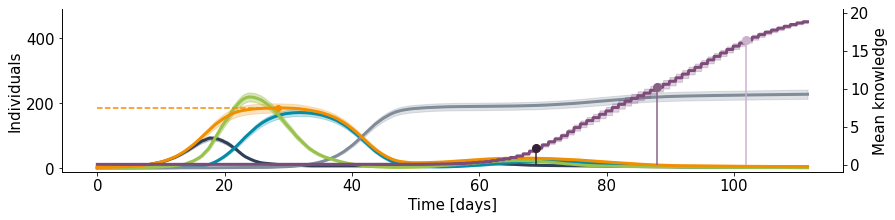

Figures/680nodes/10clusters_68nodes/time_evol_p_intra_6.21E-03_epsI_0.10_epsT_0.100_kThresh_10.000_ideas_y.pdf


In [22]:
#for p_intra in [0.00621,0.01203,0.01481,0.01605,0.01650,0.0167445]: 
for p_intra in [0.00621]: 

    p_inter = 2*L/(nb_clusters*(nb_clusters-1)*cluster_size**2) - (cluster_size-1)*p_intra/((nb_clusters-1)*cluster_size)
    print('p',p_intra/p_inter)
    graph_name = '%dnodes/%dclusters_%dnodes/temporal_net_p_intra%.2E_p_inter%.2E'%(nb_nodes,nb_clusters,cluster_size,p_intra,p_inter)
    if rounds:
        graph_name += '_rounds%ddays'%round_days
    #for eps_I in eps_I_list:
    for eps_I in [0.1]:
        #for eps_T in eps_T_list[:1]:
        for eps_T in [0.1]:
            print('eps_I',eps_I,'eps_T',eps_T)

            if save_1st_time:
                # Load
                load_res(PARAMETERS)
                # Aggregate:
                ActInf_mean, ActInf_sem = aggregate_results_inf(PARAMETERS['times'],'r%d_act_inf')
                Iso_mean, Iso_sem = aggregate_results_inf(PARAMETERS['times'],'r%d_isolated')
                Rec_mean, Rec_sem = aggregate_results_inf(PARAMETERS['times'],'r%d_recovered')
                if eps_T > 0:
                    Quar_mean, Quar_sem = aggregate_results_inf(PARAMETERS['times'],'r%d_quarantined')
                    Quar_inf_mean, Quar_inf_sem = aggregate_results_inf(PARAMETERS['times'],'r%d_quar_inf')
                Ideas_mean, Ideas_sem = aggregate_results_ideas(PARAMETERS['times'])

                # Save:
                filename = obtain_filename('Act_inf')
                np.save(filename,[ActInf_mean,ActInf_sem])

                filename = obtain_filename('Iso')
                np.save(filename,[Iso_mean,Iso_sem])

                filename = obtain_filename('Rec')
                np.save(filename,[Rec_mean,Rec_sem])

                if eps_T > 0:
                    filename = obtain_filename('Quar')
                    np.save(filename,[Quar_mean,Quar_sem])

                    filename = obtain_filename('Quar_inf')
                    np.save(filename,[Quar_inf_mean,Quar_inf_sem])  
                filename = obtain_filename('IdeasperNode')
                np.save(filename,[Ideas_mean,Ideas_sem])   

            else:
                # Load already aggregated results
                filename = obtain_filename('Act_inf')
                ActInf_mean, ActInf_sem = np.load(filename,allow_pickle=True)
                filename = obtain_filename('Iso')
                Iso_mean, Iso_sem = np.load(filename,allow_pickle=True)
                filename = obtain_filename('Rec')
                Rec_mean, Rec_sem = np.load(filename,allow_pickle=True)
                if eps_T > 0:
                    filename = obtain_filename('Quar')
                    Quar_mean,Quar_sem = np.load(filename,allow_pickle=True)
                    filename = obtain_filename('Quar_inf')
                    Quar_inf_mean,Quar_inf_sem = np.load(filename,allow_pickle=True)
                filename = obtain_filename('IdeasperNode')
                Ideas_mean,Ideas_sem = np.load(filename,allow_pickle=True)

            # Plot
            t1cl_idx,t25_idx,t50_idx,t80_idx = time_flags(PARAMETERS,nb_clusters,Ideas_mean)
            maxInf,t1cl,t25,t50,t80 = plot(t1cl_idx,t25_idx,t50_idx,t80_idx)

            # save in database
            
            if save_1st_time:        
                if eps_T == 0:
                    db = TinyDB("RESULTS/%dnodes/Aggregate_res_bubbles_%dclusters.json"%(nb_nodes,nb_clusters))
                else:
                    db = TinyDB("RESULTS/%dnodes/Aggregate_res_quarantines_%dclusters.json"%(nb_nodes,nb_clusters))

                if rounds == False:
                    rounds_flag = False
                else:
                    rounds_flag = round_days

                new_item = {"p_intra": round(p_intra,5),
                            "p": int(round(p_intra/p_inter)),
                            "epsI": eps_I, 
                            "epsT": eps_T, 
                            "Rounds": rounds_flag,
                            "maxInf": maxInf, 
                            "Time1cl": t1cl,
                            "Time25": t25,
                            "Time50": t50,
                            "Time80": t80}
                db.insert(new_item) 
            
            #db.all()
            

In [23]:
'''
for real in range(PARAMETERS['times']):
    globals()['r%d_Nodes_mean'%real] = np.mean(globals()['r%d_nodes_per_idea'%real],axis=1) # average on ideas

# I put r%d_Nodes_mean all together in a matrix:
Nodes_mean_all_real = r0_Nodes_mean
for real in range(1,PARAMETERS['times']): # for each realization
    Nodes_mean_all_real = np.hstack((Nodes_mean_all_real, globals()['r%d_Nodes_mean'%real]))

# Average over all realizations:
Nodes_mean = np.mean(Nodes_mean_all_real,axis=1)
Nodes_mean = np.array(Nodes_mean.T)[0]
Nodes_sem = sem(Nodes_mean_all_real,axis=1)
'''

#filename = 'Figures_data/%dclusters_%dnodes/NodesperIdea_p_intra_%.2E_epsI_%.2f_epsT_%.3f_kThresh_%.3f'%(nb_clusters,cluster_size,p_intra,eps_I,eps_T,K)
#if rounds:
#    filename += '_rounds%ddays'%round_days
#filename += '.npy'

# solo la prima volta
#np.save(filename,[Nodes_mean,Nodes_sem])

#Nodes_mean,Nodes_sem = np.load(filename,allow_pickle=True)

"\nfor real in range(PARAMETERS['times']):\n    globals()['r%d_Nodes_mean'%real] = np.mean(globals()['r%d_nodes_per_idea'%real],axis=1) # average on ideas\n\n# I put r%d_Nodes_mean all together in a matrix:\nNodes_mean_all_real = r0_Nodes_mean\nfor real in range(1,PARAMETERS['times']): # for each realization\n    Nodes_mean_all_real = np.hstack((Nodes_mean_all_real, globals()['r%d_Nodes_mean'%real]))\n\n# Average over all realizations:\nNodes_mean = np.mean(Nodes_mean_all_real,axis=1)\nNodes_mean = np.array(Nodes_mean.T)[0]\nNodes_sem = sem(Nodes_mean_all_real,axis=1)\n"

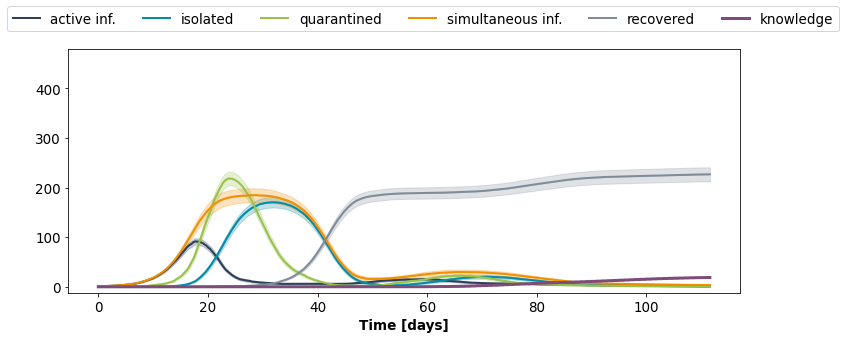

In [48]:
# legend
'''
days = np.array(range(len(ActInf_mean)))*PARAMETERS['temporal_gap']/3600/24
alpha = 0.25

fig, ax1 = plt.subplots(figsize=(12,5))
plot_avg_std(ActInf_mean,ActInf_sem,days,alpha,act_inf_color,act_inf_color,'-',ax1,2,'active inf.')
plot_avg_std(Iso_mean,Iso_sem,days,alpha,iso_color,iso_color,'-',ax1,2,'isolated')


if eps_T > 0:
    plot_avg_std(Quar_mean,Quar_sem,days,alpha,quar_color,quar_color,'-',ax1,2,'quarantined')
    nb_inf_mean = Iso_mean+ActInf_mean+Quar_inf_mean
    nb_inf_sem = Iso_sem+ActInf_sem+Quar_inf_sem
elif eps_T == 0:
    nb_inf_mean = Iso_mean+ActInf_mean
    nb_inf_sem = Iso_sem+ActInf_sem
plot_avg_std(nb_inf_mean,nb_inf_sem,days,alpha,sim_inf_color,sim_inf_color,'-',ax1,2,'simultaneous inf.')

plot_avg_std(Rec_mean,Rec_sem,days,alpha,rec_color,rec_color,'-',ax1,2,'recovered')

plot_avg_std(Ideas_mean,Ideas_sem,days,alpha,know_color,know_color,'-',ax1,3,'knowledge')

if all(el == PARAMETERS['k_threshold'][0] for el in PARAMETERS['k_threshold']): # True if all K are the same
    K = PARAMETERS['k_threshold'][0]
plt.gca().set_ylim(top=480)
ax1.legend(loc='upper left',ncol=6, bbox_to_anchor=(-0.1, 1.2))
ax1.set_xlabel('Time [days]',fontweight='bold') 

fig.tight_layout()

figname = '../../figs/legend.pdf'
fig.savefig(figname)
plt.show()
'''

In [47]:
plt.rcParams.update({'font.size': 13.5})